-105 327 432
[0. 0. 0. ... 0. 0. 0.]
-142 290 432
-69 365 434
[0. 0. 0. ... 0. 0. 0.]


<Figure size 1080x432 with 0 Axes>

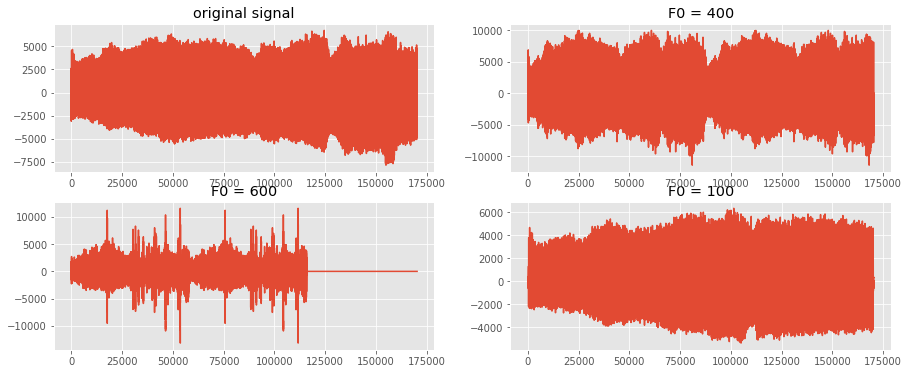

In [7]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
import scipy.io.wavfile as spwav
from IPython.display import Audio
#from mpldatacursor import datacursor
import sys
'''
The entire signal will be voiced.
The epoch locations in the original signal are precomputed and given as epoch_marks_orig,
a NumPy array containing the indices of each epoch marker.
TD-PSOLA can be computed over the entire signal, not just individual frames.

This leaves remapping, windowing, and overlap-adding for you to implement as described 
in the Overlap-Add Algorithm section. Your implementation will be expected to work for 
any synthesis frequency within the nominal human vocalization range [100 Hz, 600 Hz].

A quick implementation note -- earlier in the lab notes, we assumed some fixed P_0 for 
our entire signal and computed our window as length N = 2 * P_0 + 1. This assumes our 
signal is unchanging over time, which is clearly not true.

Instead, compute P_0 as the average of the distance between the nearest two epochs, 
ie P_0 = (epoch[i + 1] - epoch[i - 1]) / 2 for your current epoch i.
'''
plt.style.use('ggplot')

# Note: this epoch list only holds for "test_vector_all_voiced.wav"
epoch_marks_orig = np.load("test_vector_all_voiced_epochs.npy")
F_s, audio_data = spwav.read("test_vector_all_voiced.wav")
N = len(audio_data)
#print(audio_data)
######################## YOUR CODE HERE ##############################
'''
Implement TD-PSOLA on the given test file using the starter Python code given.
Try for various frequencies, F_new = 100, 200, 300, 400 etc.
'''
#F_new = 420
#new_epoch_spacing = int(F_s/F_new)
P0 = np.zeros(len(epoch_marks_orig)-2, dtype = 'int')
P0[-1] = epoch_marks_orig[-1] - epoch_marks_orig[-2]
y = []  # store windowed response, len = epoch mark - 2

for i in range(1, len(epoch_marks_orig)-1): # extract top and bottom
    start = epoch_marks_orig[i-1]
    end = epoch_marks_orig[i+1]
    cur = epoch_marks_orig[i]
    P0[i-1] = int((end - start)/2)  #P0 for each epochs
    # extract the impulse response (rather, an estimate of the impulse response) 
    # by windowing ±P0 about each epoch marker.
    w = np.hamming(2*P0[i-1])
    y.append(np.multiply(audio_data[ cur - P0[i-1] : cur + P0[i-1] ], w))
    #y.append(audio_data[cur - P0[i-1]: cur + P0[i-1]])
P0_avg = sum(P0)/len(P0)   # fundamental period
F0 = int(F_s/P0_avg)
Fn = [100, 400, 600]
ratio = np.zeros(len(Fn), dtype='float64')
Pn_avg = np.zeros(len(Fn), dtype = 'int')   # new epoch spacings
Pn = np.zeros((len(Fn), len(P0)), dtype = 'int')

for i in range(len(Fn)):
    ratio[i] = Fn[i] / F0
    Pn_avg[i] = int(P0_avg/ratio[i])
    for n in range(len(P0)):
        Pn[i, :] = P0/ratio[i]  # new_epoch_spacing
#print(y)
# Suggested loop
def get_audio(n, N, Pn, P0, y):
    audio_new = np.zeros(N)
    #n = index
    P = 0   #position of the new epoch
    zero_start = 0
    for i in range(len(P0)):
        P+=Pn[n,i]      # epoch position
        yl = len(y[i])  #length of the windowed frame
        start = P - int(yl/2)
        end = P + yl - int(yl/2)
        if ratio[n] < 1:    #zeropadding
            #print(P + yl - int(yl/2) - (P - int(yl/2))+1)
            if end > N:   #boundary
                audio_new[start: N-1] += y[i][0:N-1-start]
                return(audio_new)
            else:
                audio_new[ start : end ] += y[i]
        else:   #overlapping
            # boundary
            if (start < 0):
                print(start, end, yl)
                audio_new[ 0 : end ] += y[i][-start-1:-1]
            else:
                audio_new[ start : end ] += y[i]
                zero_start = end
    print(audio_new [ zero_start : -1 ])
    length = len(audio_new[zero_start: -1])
    audio_new[zero_start:-1] = audio_new[0:length]
    return(audio_new)

out = [] 

plt.figure(figsize = (15,6))

plt.figure(figsize = (15,6))
for i in range(len(Fn)):
    out.append(get_audio(i,N,Pn,P0,y))
    
plt.subplot(221)
plt.title('original signal')
plt.plot(audio_data)

plt.subplot(224)
plt.title('F0 = 100')
plt.plot(out[0])
plt.subplot(222)
plt.title('F0 = 400')
plt.plot(out[1])
plt.subplot(223)
plt.title('F0 = 600')
plt.plot(out[2])

plt.show()